In [1]:
import numpy as np
import pandas as pd

def compute_velocity(df):
    """
    Compute instantaneous speed (velocity magnitude) assuming unit time intervals.
    Velocity at step i = distance between point i and i+1.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    speed = np.sqrt(dx**2 + dy**2)
    return speed

def compute_acceleration(velocity):
    """
    Compute acceleration as discrete time derivative of speed.
    Acceleration at step i = velocity[i+1] - velocity[i].
    """
    return np.diff(velocity)

def compute_jerk(acceleration):
    """
    Compute jerk as discrete time derivative of acceleration.
    Jerk at step i = acceleration[i+1] - acceleration[i].
    """
    return np.diff(acceleration)

def compute_angle(df):
    """
    Compute heading angle of movement vectors.
    Angle at step i = arctan2(dy, dx) between consecutive points.
    Unwrap to avoid discontinuities at ±π.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    angle = np.arctan2(dy, dx)
    return np.unwrap(angle)

def compute_angular_velocity(angle):
    """
    Compute angular velocity as discrete time derivative of heading angle.
    """
    return np.diff(angle)

def compute_angular_acceleration(angular_velocity):
    """
    Compute angular acceleration as discrete time derivative of angular velocity.
    """
    return np.diff(angular_velocity)

def compute_straightness(df):
    """
    Compute local straightness over sliding windows of 3 points.
    """
    x, y = df['x'].values, df['y'].values
    n = len(x)
    s = []
    for i in range(n - 2):
        p0, p1, p2 = np.array([x[i], y[i]]), np.array([x[i+1], y[i+1]]), np.array([x[i+2], y[i+2]])
        disp = np.linalg.norm(p2 - p0)
        path = np.linalg.norm(p1 - p0) + np.linalg.norm(p2 - p1)
        s.append(disp / path if path != 0 else np.nan)
    return np.array(s)


def compute_curvature(df, eps=1e-8):
    """
    Estimate curvature at each point using discrete derivatives:
      k = |x' y'' - y' x''| / (x'^2 + y'^2)^(3/2)
    
    To avoid division by zero, we:
      1) compute denom = (dx^2 + dy^2)**1.5
      2) replace any denom < eps with eps
      3) compute k safely
      4) set curvature to 0 where the movement is truly stationary
    """
    x = df['x'].values
    y = df['y'].values

    # first derivatives
    dx = np.gradient(x)
    dy = np.gradient(y)
    # second derivatives
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    # numerator of curvature formula
    num = np.abs(dx * ddy - dy * ddx)
    # denominator, with small epsilon floor
    denom = (dx**2 + dy**2)**1.5
    denom = np.where(denom < eps, eps, denom)

    k = num / denom

    return k

def compute_stillness(df):
    """
    Count timesteps where the insect is still:
    Positions where both x and y do not change from previous frame.
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    # Still when no movement in both axes
    return int(np.sum((dx == 0) & (dy == 0)))

import numpy as np
from scipy.spatial import ConvexHull

def compute_step_length_stats(df):
    """
    Compute statistics of the step-length distribution (distances between successive points).
    Returns a dict with:
      - mean: average step length
      - variance: variance of step lengths
      - skewness: measure of asymmetry of the distribution
      - kurtosis: excess kurtosis (peakedness relative to normal)
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    steps = np.sqrt(dx**2 + dy**2)
    μ = np.mean(steps)
    σ = np.std(steps)
    skew = np.mean((steps - μ)**3) / σ**3 if σ > 0 else np.nan
    kurt = np.mean((steps - μ)**4) / σ**4 - 3 if σ > 0 else np.nan
    return {
        'step_mean': μ,
        'step_variance': σ**2,
        'step_skewness': skew,
        'step_kurtosis': kurt
    }

def compute_turning_angle_stats(df):
    """
    Compute turning-angle features:
      - mean_resultant_length: directional persistence
      - var, skewness, kurtosis of the turn-angle distribution
    Angles are wrapped to [-π, π].
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    angles = np.arctan2(dy, dx)
    turns = np.diff(angles)
    # wrap turns into [-π,π]
    turns = (turns + np.pi) % (2 * np.pi) - np.pi
    
    n = len(turns)
    cr = np.sum(np.cos(turns)) / n
    sr = np.sum(np.sin(turns)) / n
    mean_res_len = np.sqrt(cr**2 + sr**2)
    
    μ = np.mean(turns)
    σ = np.std(turns)
    skew = np.mean((turns - μ)**3) / σ**3 if σ > 0 else np.nan
    kurt = np.mean((turns - μ)**4) / σ**4 - 3 if σ > 0 else np.nan
    
    return {
        'turn_mrl': mean_res_len,
        'turn_variance': σ**2,
        'turn_skewness': skew,
        'turn_kurtosis': kurt
    }

def compute_pause_bout_stats(df, speed_thresh=1e-2):
    """
    Detect pause bouts where instantaneous speed < speed_thresh.
    Returns:
      - n_pauses: number of pause bouts
      - mean_pause_duration: average frames per pause
      - median_pause_duration
      - fraction_paused: total paused frames / total steps
      - pause_to_move_rate: transitions from pause to move per frame
      - move_to_pause_rate: transitions from move to pause per frame
    """
    dx = np.diff(df['x'].values)
    dy = np.diff(df['y'].values)
    speed = np.sqrt(dx**2 + dy**2)
    paused = speed < speed_thresh
    
    # find transitions
    trans = np.diff(paused.astype(int))
    starts = np.where(trans == 1)[0] + 1  # move→pause
    ends   = np.where(trans == -1)[0] + 1 # pause→move
    
    # handle edge cases if track starts or ends paused
    if paused[0]:
        starts = np.insert(starts, 0, 0)
    if paused[-1]:
        ends = np.append(ends, len(paused))
    
    durations = ends - starts
    n_pauses = len(durations)
    
    return {
        'n_pauses': n_pauses,
        'mean_pause_dur': np.mean(durations) if n_pauses > 0 else 0,
        'median_pause_dur': np.median(durations) if n_pauses > 0 else 0,
        'fraction_paused': np.sum(paused) / len(paused),
        'pause_to_move_rate': len(ends) / len(paused),
        'move_to_pause_rate': len(starts) / len(paused)
    }

import numpy as np
from scipy.spatial import ConvexHull, QhullError

def compute_convex_hull_area(df):
    """
    Compute the area of the convex hull enclosing the track points.
    Returns 0.0 if fewer than 3 unique points.
    """
    pts = np.vstack([df['x'].values, df['y'].values]).T

    # need at least 3 total points *and* 3 unique points
    if len(pts) < 3:
        return 0.0

    # filter out duplicates
    unique_pts = np.unique(pts, axis=0)
    if unique_pts.shape[0] < 3:
        return 0.0

    # now it’s safe to compute
    try:
        hull = ConvexHull(unique_pts)
        return hull.volume
    except QhullError:
        # just in case some other degeneracy slips through
        return 0.0

def compute_radius_of_gyration(df):
    """
    Compute the radius of gyration:
    sqrt(mean((x - x_mean)^2 + (y - y_mean)^2))
    Measures how tightly the path clusters around its centroid.
    """
    x = df['x'].values
    y = df['y'].values
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return np.sqrt(np.mean((x - x_mean)**2 + (y - y_mean)**2))



import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

def summarize(arr, name):
    """
    Compute summary statistics for an array:
    - mean
    - median
    - minimum
    - maximum
    - variance

    If arr is empty or all NaNs, every statistic will be np.nan.
    """
    # Drop NaNs
    arr_clean = arr[~np.isnan(arr)]
    
    # If no valid data, return all NaNs
    if arr_clean.size == 0:
        return {
            f"{name}_mean":     np.nan,
            f"{name}_median":   np.nan,
            f"{name}_min":      np.nan,
            f"{name}_max":      np.nan,
            f"{name}_variance": np.nan,
        }
    
    # Otherwise compute stats safely
    μ        = np.nanmean(arr_clean)
    median   = np.nanmedian(arr_clean)
    _min     = np.nanmin(arr_clean)
    _max     = np.nanmax(arr_clean)
    variance = np.nanvar(arr_clean)
    
    return {
        f"{name}_mean":     μ,
        f"{name}_median":   median,
        f"{name}_min":      _min,
        f"{name}_max":      _max,
        f"{name}_variance": variance,
    }

def extract_features(df):
    """
    Compute summary statistics of kinematic and geometric features:
    - velocity, acceleration, jerk
    - angle, angular velocity, angular acceleration
    - straightness, curvature
    - stillness count
    - step-length distribution stats
    - turning-angle distribution stats
    - pause-bout metrics
    - convex-hull area
    - radius of gyration

    Returns a pandas Series with all features.
    """
    # 1) Raw kinematic/geometric arrays
    vel       = compute_velocity(df)
    acc       = compute_acceleration(vel)
    jerk      = compute_jerk(acc)
    angle     = compute_angle(df)
    ang_vel   = compute_angular_velocity(angle)
    ang_acc   = compute_angular_acceleration(ang_vel)
    straight  = compute_straightness(df)
    curvature = compute_curvature(df)
    still_cnt = compute_stillness(df)

    # 2) Summarize arrays (mean, median, min, max, variance, skewness, kurtosis)
    features = {}
    for arr, name in [
        (vel, "velocity"), (acc, "acceleration"), (jerk, "jerk"),
        (angle, "angle"), (ang_vel, "angular_velocity"),
        (ang_acc, "angular_acceleration"),
        (straight, "straightness"), (curvature, "curvature")
    ]:
        features.update(summarize(arr, name))

    # 3) Add scalar features
    features["stillness_count"] = still_cnt

    # 4) Add distributional stats
    #features.update(compute_step_length_stats(df))
    features.update(compute_turning_angle_stats(df))
    #features.update(compute_pause_bout_stats(df))

    # 5) Add spatial metrics
    features["convex_hull_area"]   = compute_convex_hull_area(df)
    features["radius_of_gyration"] = compute_radius_of_gyration(df)

    return pd.Series(features)

# Ensure compute_* helper functions remain as defined previously.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

# 1) load your data
from utils.data_loading import load_dataset
train_data, val_data, test_data, full_training_data = load_dataset(
    "datasets/it-trajs_complete", diff=False, scaler=None, augment=False
)

def build_X_y(dataset):
    feats, labels = [], []
    for fname, track in dataset.tracks_dict.items():
        try:
            feats.append(extract_features(track['dataframe']))
        except Exception as E:
            print(E)
            print(f"filename: {fname}")
            print(track)
            exit()
       
        labels.append(int(track['label']))
    X = pd.DataFrame(feats)
    y = pd.Series(labels, name='label', dtype=int)
    return X, y

# 2) build feature matrices
X_train, y_train = build_X_y(full_training_data)
X_test,  y_test  = build_X_y(test_data)

# 3) candidate models
models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost':       XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1),
    'SVM':           SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'DecisionTree':  DecisionTreeClassifier(random_state=42, class_weight='balanced'),
}

# 4) hyperparameter grids
param_grids = {
    'RandomForest': {
        'clf__n_estimators':     [100, 300, 500],
        'clf__max_depth':        [None, 10, 20],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'clf__n_estimators': [100, 300],
        'clf__learning_rate':[0.01, 0.1],
        'clf__max_depth':    [3, 6, 10]
    },
    'SVM': {
        'clf__C':     [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto']
    },
    'DecisionTree': {
        'clf__max_depth':        [None, 10, 20],
        'clf__min_samples_split':[2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
}

# 5) cross-validation setup
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['f1_macro', 'accuracy', 'precision_macro', 'recall_macro']

# 6) tuning and repeated test evaluation
n_repeats = 20
seeds = list(range(n_repeats))

for name, clf in models.items():
    print(f"\n=== {name} ===")
    # build pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler',  StandardScaler()),
        ('clf',     clf)
    ])
    from sklearn.exceptions import UndefinedMetricWarning
    import warnings

    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    # grid search
    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=cv,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV f1_macro: {grid.best_score_:.3f}")

    from sklearn.metrics import confusion_matrix

    # repeated test performance
    accs, ba_accs, precs, recs, f1s = [], [], [], [], []
    cms = []  # <-- collect confusion matrices

    for seed in seeds:
        model = clone(grid.best_estimator_)
        try:
            model.set_params(clf__random_state=seed)
        except ValueError:
            pass

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # compute metrics
        accs.append(accuracy_score(y_test, y_pred))
        ba_accs.append(balanced_accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        recs.append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        f1s.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        # confusion matrix for this run
        cms.append(confusion_matrix(y_test, y_pred))

    # summarize repeated performance
    print(f"\nTest Performance over {n_repeats} runs:")
    print(f"Accuracy            : {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"Balanced Accuracy   : {np.mean(ba_accs):.3f} ± {np.std(ba_accs):.3f}")
    print(f"Precision macro     : {np.mean(precs):.3f} ± {np.std(precs):.3f}")
    print(f"Recall macro        : {np.mean(recs):.3f} ± {np.std(recs):.3f}")
    print(f"F1 macro            : {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")

    # now aggregate confusion matrices
    sum_cm = sum(cms)           # total counts across all runs
    avg_cm = sum_cm / len(cms)  # average per-run

    print("\nSummed confusion matrix (counts summed over runs):")
    print(sum_cm)

    print("\nAverage confusion matrix (averaged over runs):")
    print(np.round(avg_cm, 2))




=== RandomForest ===
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Best parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 100}
Best CV f1_macro: 0.478

Test Performance over 10 runs:
Accuracy            : 0.768 ± 0.008
Balanced Accuracy   : 0.523 ± 0.025
Precision macro     : 0.544 ± 0.033
Recall macro        : 0.523 ± 0.025
F1 macro            : 0.512 ± 0.028

Summed confusion matrix (counts summed over runs):
[[2882   19   43  536]
 [ 109   24   15   12]
 [  77    4   81   18]
 [ 144   28    0  338]]

Average confusion matrix (averaged over runs):
[[288.2   1.9   4.3  53.6]
 [ 10.9   2.4   1.5   1.2]
 [  7.7   0.4   8.1   1.8]
 [ 14.4   2.8   0.   33.8]]

=== XGBoost ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Best parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300}
Best CV f1_macro: 0.401

Test Performance over 10 runs:
Accuracy            : 0.827 ± 0.000
Balanced Accuracy   : 0.409 ± 0.000
Precision macro     : 0.745 ± 0.000
Recall macro        : 0.409 ± 0.000
F1 macro            : 0.476 ± 0.000

Summed confusion matrix (counts summed over runs):
[[3380   10    0   90]
 [ 130   30    0    0]
 [ 140    0   40    0]
 [ 370    0   10  130]]

Average confusion matrix (averaged over runs):
[[338.   1.   0.   9.]
 [ 13.   3.   0.   0.]
 [ 14.   0.   4.   0.]
 [ 37.   0.   1.  13.]]

=== SVM ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'clf__C': 10, 'clf__gamma': 'scale'}
Best CV f1_macro: 0.462

Test Performance over 10 runs:
Accuracy            : 0.767 ± 0.000
Balanced Accuracy   : 0.592 ± 0.000
Precision macro     : 0.502 ± 0.000
Recall macro        : 0.592 ± 0.000
F1 macro            : 0.536 ± 0.000

Summed confusion matr

/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/miniconda3/envs/ann/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best CV f1_macro: 0.350

Test Performance over 10 runs:
Accuracy            : 0.788 ± 0.000
Balanced Accuracy   : 0.369 ± 0.000
Precision macro     : 0.491 ± 0.000
Recall macro        : 0.369 ± 0.000
F1 macro            : 0.400 ± 0.000

Summed confusion matrix (counts summed over runs):
[[3230    0   20  230]
 [ 120   20   10   10]
 [ 140    0   30   10]
 [ 330   30   20  130]]

Average confusion matrix (averaged over runs):
[[323.   0.   2.  23.]
 [ 12.   2.   1.   1.]
 [ 14.   0.   3.   1.]
 [ 33.   3.   2.  13.]]


Top 10 features by RF impurity‐based importance:
velocity_variance            0.034143
turn_mrl                     0.031403
jerk_variance                0.030156
straightness_variance        0.029600
turn_variance                0.029380
curvature_median             0.028907
velocity_median              0.028714
convex_hull_area             0.028179
angular_velocity_variance    0.027879
radius_of_gyration           0.027590
dtype: float64


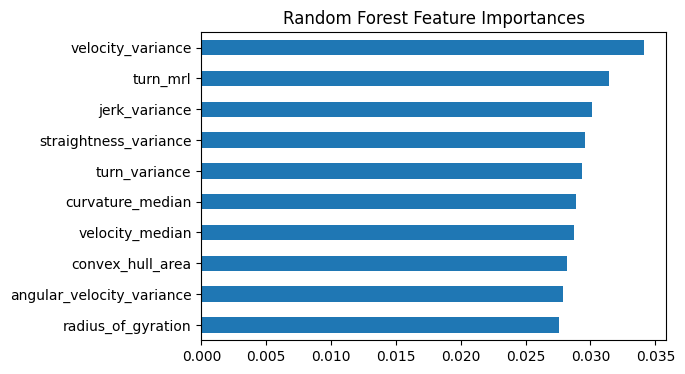

Top 10 features by permutation importance (on test set):
velocity_min                0.022029
angular_acceleration_min    0.021554
straightness_mean           0.014383
curvature_min               0.011558
turn_kurtosis               0.010502
acceleration_median         0.008584
angular_velocity_min        0.008495
angular_velocity_max        0.007329
stillness_count             0.007182
angle_median                0.007140
dtype: float64


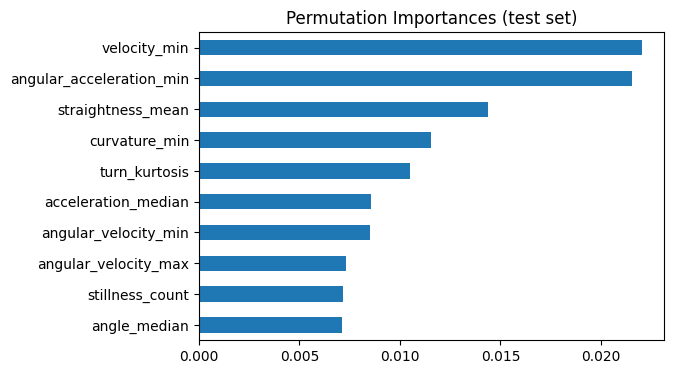

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance

# 1) Fit your RandomForest pipeline on the full training data
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('clf',     RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
])
rf_pipe.fit(X_train, y_train)

# 2) Extract the fitted RF and feature names
rf = rf_pipe.named_steps['clf']
feature_names = X_train.columns

# 3a) Tree-based importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

print("Top 10 features by RF impurity‐based importance:")
print(feat_imp.head(10))

# (Optional) bar-plot
plt.figure(figsize=(6,4))
feat_imp.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importances")
plt.show()

from sklearn.inspection import permutation_importance

# 1) Fit on training set (as before)
rf_pipe.fit(X_train, y_train)

# 2) Compute permutation importances on the *test* set
perm_imp = permutation_importance(
    rf_pipe, 
    X_test,                   # <— use held-out data, not X_train
    y_test, 
    n_repeats=20,             # more repeats → smoother estimates
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'        # pick the metric you care about
)

# 3) Turn into a sorted Series
perm_series = pd.Series(
    perm_imp.importances_mean, 
    index=X_train.columns
).sort_values(ascending=False)

# 4) Inspect top features
print("Top 10 features by permutation importance (on test set):")
print(perm_series.head(10))

# 5) Plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
perm_series.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Permutation Importances (test set)")
plt.show()
